# OpenWeather APIs
This is my first foray into retrieving data from API calls and making plots using Python. Here, I work with the Air Pollution and Geocoding APIs of OpenWeather.

In [1]:
import requests # common library for making requests and working with APIs
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import seaborn as sns
import re

from datetime import datetime, date

In [2]:
# list of available styles 
plt.style.available

['Solarize_Light2',
 '_classic_test_patch',
 '_mpl-gallery',
 '_mpl-gallery-nogrid',
 'bmh',
 'classic',
 'dark_background',
 'fast',
 'fivethirtyeight',
 'ggplot',
 'grayscale',
 'seaborn-v0_8',
 'seaborn-v0_8-bright',
 'seaborn-v0_8-colorblind',
 'seaborn-v0_8-dark',
 'seaborn-v0_8-dark-palette',
 'seaborn-v0_8-darkgrid',
 'seaborn-v0_8-deep',
 'seaborn-v0_8-muted',
 'seaborn-v0_8-notebook',
 'seaborn-v0_8-paper',
 'seaborn-v0_8-pastel',
 'seaborn-v0_8-poster',
 'seaborn-v0_8-talk',
 'seaborn-v0_8-ticks',
 'seaborn-v0_8-white',
 'seaborn-v0_8-whitegrid',
 'tableau-colorblind10']

In [3]:
# set style for plots
plt.style.use('seaborn-v0_8-pastel')
plt.rcParams['figure.figsize'] = (10, 4) # width and height

In [4]:
# input here API key from https://openweathermap.org/
API_KEY = ' ' 

## Direct geocoding

The Air Pollution API requires longitude and latitude coordinates of the area of interest, so direct geocoding is needed, in which the specified name of a location is converted to exact geographical coordinates.

In [5]:
# set API endpoint for GeoCoder API
url = "http://api.openweathermap.org/geo/1.0/direct?"

# for now, we hardcode the location name, but ideally, this will be user-supplied
# maybe best to include a dropdown list so only "valid" locations can be submitted
# alternatively, user can provide geocoordinates, provided that they are valid (specify format)
city = "Quezon City"
state = ""
country = "PH"
q = city + "," + state + "," + country

# condense in payload variable
payload = {'q': q, 'appid': API_KEY, 'limit': 1}

# make request
r = requests.get(url, params=payload)
# check status code
print(r.status_code)
# r.raise_for_status

200


In [6]:
# decode json
json = r.json()
json[0]

{'name': 'Quezon City',
 'local_names': {'uk': 'Кесон-Сіті',
  'ur': 'کیزون سٹی',
  'it': 'Città Quezon',
  'tl': 'Lungsod Quezon',
  'en': 'Quezon City',
  'eo': 'Kesonurbo',
  'he': 'קואזון סיטי',
  'af': 'Quezon Stad',
  'fa': 'کزون سیتی',
  'kn': 'ಕೇಜೊನ್',
  'ca': 'Ciutat Quezon',
  'es': 'Ciudad Quezón',
  'ja': 'ケソンシティ',
  'pt': 'Cidade Quezon',
  'ko': '케손시티',
  'ru': 'Кесон-Сити',
  'ar': 'مدينة كيزون',
  'zh': '计顺市'},
 'lat': 14.6509905,
 'lon': 121.0486155,
 'country': 'PH'}

GeoCoder returns a list containing a single dictionary since the number of locations in the API response is limited to one.

## Current air pollution data

In [7]:
# get latitude and longitude of 1st element, to be used for the Air Pollution API
lat = json[0]['lat']
lon = json[0]['lon']

In [8]:
# sets API endpoint for Air Pollution API
url = "http://api.openweathermap.org/data/2.5/air_pollution?"

In [9]:
# condense in payload variable
payload = {'lat': lat, 'lon': lon, 'appid': API_KEY}
payload

{'lat': 14.6509905,
 'lon': 121.0486155,
 'appid': 'dd755d4efbd0a01b934aea0e82f53557'}

In [10]:
# make request and check status code
r = requests.get(url, params=payload)
print(r.status_code)

200


In [11]:
# decode json
json = r.json()
json

{'coord': {'lon': 121.0486, 'lat': 14.651},
 'list': [{'main': {'aqi': 2},
   'components': {'co': 520.71,
    'no': 0.64,
    'no2': 12.34,
    'o3': 68.67,
    'so2': 14.54,
    'pm2_5': 9.82,
    'pm10': 20.06,
    'nh3': 4.69},
   'dt': 1697166302}]}

The Air Pollution API returns a dictionary contaning coordinates and a list. The list contains the air quality index (where 1 = good, 2 = fair, 3 = moderate, 4 = poor, and 5 = very poor), measures of air pollution, and the date and time the API call was made (Unix, UTC).

In [12]:
# extract AQI
json.get('list')[0].get('main').get('aqi')

2

In [13]:
# extract the components
components = json.get('list')[0].get('components')
components['co']
components

{'co': 520.71,
 'no': 0.64,
 'no2': 12.34,
 'o3': 68.67,
 'so2': 14.54,
 'pm2_5': 9.82,
 'pm10': 20.06,
 'nh3': 4.69}

In [14]:
# extract the date and time stamp
ts = json.get('list')[0].get('dt')
# format to human-readable (local) time
time = datetime.fromtimestamp(ts).strftime('%Y-%m-%d %H:%M:%S')
time

'2023-10-13 11:05:02'

In [16]:
# extract coordinates and combine with components dictionary
json.get('coord') | components

{'lon': 121.0486,
 'lat': 14.651,
 'co': 520.71,
 'no': 0.64,
 'no2': 12.34,
 'o3': 68.67,
 'so2': 14.54,
 'pm2_5': 9.82,
 'pm10': 20.06,
 'nh3': 4.69}

## Historical air pollution data

We then sample historical pollution data using the same coordinates obtained from the Geocoder API. Besides lat, lon, and appid, start and end parameters must be supplied (in unix time, UTC time zone). Note that start date should not be earlier than 27th November 2020.

In [17]:
# set API endpoint for retrieving historical data
url = "http://api.openweathermap.org/data/2.5/air_pollution/history?"

# set start and end parameters
# hard-coded for now
start = int(datetime(2020, 11, 27, 0, 0, 0).timestamp())
end = int(datetime(2020, 12, 31, 0, 0, 0).timestamp())

In [18]:
# condense parameters in payload variable
payload = {'lat': lat, 'lon': lon, 'start': start, 'end': end, 'appid': API_KEY}
payload

{'lat': 14.6509905,
 'lon': 121.0486155,
 'start': 1606406400,
 'end': 1609344000,
 'appid': 'dd755d4efbd0a01b934aea0e82f53557'}

In [19]:
# make request and check status code
r = requests.get(url, params=payload)
print(r.status_code)

200


In [20]:
# decode json
json = r.json()
# get a list of json objects / a list of dictionaries
json.get('list')

[{'main': {'aqi': 4},
  'components': {'co': 1214.98,
   'no': 0.05,
   'no2': 40.1,
   'o3': 23.6,
   'so2': 21.46,
   'pm2_5': 33.63,
   'pm10': 45.66,
   'nh3': 6.52},
  'dt': 1606406400},
 {'main': {'aqi': 4},
  'components': {'co': 1281.74,
   'no': 0.12,
   'no2': 41.47,
   'o3': 16.81,
   'so2': 20.74,
   'pm2_5': 35.85,
   'pm10': 48.27,
   'nh3': 7.03},
  'dt': 1606410000},
 {'main': {'aqi': 4},
  'components': {'co': 1375.2,
   'no': 0.22,
   'no2': 41.13,
   'o3': 12.34,
   'so2': 21.7,
   'pm2_5': 41.63,
   'pm10': 56.26,
   'nh3': 9.63},
  'dt': 1606413600},
 {'main': {'aqi': 4},
  'components': {'co': 1455.31,
   'no': 0.55,
   'no2': 40.78,
   'o3': 8.32,
   'so2': 23.6,
   'pm2_5': 47.88,
   'pm10': 64.22,
   'nh3': 12.16},
  'dt': 1606417200},
 {'main': {'aqi': 5},
  'components': {'co': 1508.71,
   'no': 1.69,
   'no2': 40.78,
   'o3': 3.67,
   'so2': 28.61,
   'pm2_5': 54.58,
   'pm10': 72.08,
   'nh3': 15.83},
  'dt': 1606420800},
 {'main': {'aqi': 5},
  'components

In [21]:
# check result
json

{'coord': {'lon': 121.0486, 'lat': 14.651},
 'list': [{'main': {'aqi': 4},
   'components': {'co': 1214.98,
    'no': 0.05,
    'no2': 40.1,
    'o3': 23.6,
    'so2': 21.46,
    'pm2_5': 33.63,
    'pm10': 45.66,
    'nh3': 6.52},
   'dt': 1606406400},
  {'main': {'aqi': 4},
   'components': {'co': 1281.74,
    'no': 0.12,
    'no2': 41.47,
    'o3': 16.81,
    'so2': 20.74,
    'pm2_5': 35.85,
    'pm10': 48.27,
    'nh3': 7.03},
   'dt': 1606410000},
  {'main': {'aqi': 4},
   'components': {'co': 1375.2,
    'no': 0.22,
    'no2': 41.13,
    'o3': 12.34,
    'so2': 21.7,
    'pm2_5': 41.63,
    'pm10': 56.26,
    'nh3': 9.63},
   'dt': 1606413600},
  {'main': {'aqi': 4},
   'components': {'co': 1455.31,
    'no': 0.55,
    'no2': 40.78,
    'o3': 8.32,
    'so2': 23.6,
    'pm2_5': 47.88,
    'pm10': 64.22,
    'nh3': 12.16},
   'dt': 1606417200},
  {'main': {'aqi': 5},
   'components': {'co': 1508.71,
    'no': 1.69,
    'no2': 40.78,
    'o3': 3.67,
    'so2': 28.61,
    'pm2_5': 

In [22]:
# get length of result
len(json)

2

In [23]:
# extract values of coord key
json.get('coord')

{'lon': 121.0486, 'lat': 14.651}

In [25]:
# get length of list
len(json.get('list'))

817

The result is a dictionary of size two with keys 'coord' and 'list'. The length of the list returned corresponds to the number of data points between start and end date.

In [26]:
# normalize semi-structured json data into a flat table
df = pd.json_normalize(json.get('list'))
df.head()

,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
0,1606406400,4,1214.98,0.05,40.10,23.60,21.46,33.63,45.66,6.52
1,1606410000,4,1281.74,0.12,41.47,16.81,20.74,35.85,48.27,7.03
2,1606413600,4,1375.20,0.22,41.13,12.34,21.70,41.63,56.26,9.63
3,1606417200,4,1455.31,0.55,40.78,8.32,23.60,47.88,64.22,12.16
4,1606420800,5,1508.71,1.69,40.78,3.67,28.61,54.58,72.08,15.83


In [27]:
# convert timestamp to human-readable datetime
df.dt = (df.dt.apply(lambda x: datetime.fromtimestamp(x)))
df['dt'] = pd.to_datetime(df['dt'])

In [28]:
# get earliest date
min(df['dt']).strftime("%Y-%m-%d")

'2020-11-27'

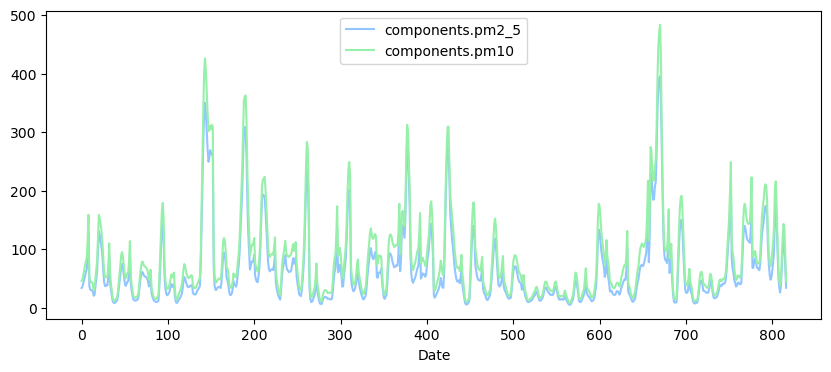

In [29]:
# draw plot
df[['components.pm2_5', 'components.pm10']].plot()
plt.xlabel('Date')

plt.show()

Hourly concentrations of fine and course particulate matter are plotted above. It may be good to plot the average daily concentrations instead.

In [30]:
# set columns of interest
cols = ['main.aqi', 'components.co', 'components.no', 'components.no2', 'components.o3', 'components.so2', 'components.pm2_5', 'components.pm10', 'components.nh3']
# group by date 
grouped = df.groupby(pd.to_datetime(df['dt'].dt.date))
# save daily averages to dataframe
daily = grouped[cols].mean()
daily.head()

,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3
dt,,,,,,,,,
2020-11-27,4.375000,2159.039583,40.683750,38.799583,6.840417,40.601250,61.204167,79.540417,17.390417
2020-11-28,3.541667,1390.497500,20.455000,27.247500,16.487083,29.807917,39.228750,52.397083,15.503333
2020-11-29,3.666667,1364.629167,13.827083,29.889167,12.712500,26.265417,38.522917,50.664167,12.570417
2020-11-30,3.666667,1491.328750,15.417083,30.845000,35.037917,22.500417,48.140000,63.410833,10.813750
2020-12-01,3.208333,1034.459167,2.315417,35.279167,40.679583,25.630417,27.589583,41.156667,11.479583


In [31]:
# convert index to datetime
# daily.index = pd.to_datetime(daily.index)
# check if index is in datetime format
daily.index

DatetimeIndex(['2020-11-27', '2020-11-28', '2020-11-29', '2020-11-30',
               '2020-12-01', '2020-12-02', '2020-12-03', '2020-12-04',
               '2020-12-05', '2020-12-06', '2020-12-07', '2020-12-08',
               '2020-12-09', '2020-12-10', '2020-12-11', '2020-12-12',
               '2020-12-13', '2020-12-14', '2020-12-15', '2020-12-16',
               '2020-12-17', '2020-12-18', '2020-12-19', '2020-12-20',
               '2020-12-21', '2020-12-22', '2020-12-23', '2020-12-24',
               '2020-12-25', '2020-12-26', '2020-12-27', '2020-12-28',
               '2020-12-29', '2020-12-30', '2020-12-31'],
              dtype='datetime64[ns]', name='dt', freq=None)

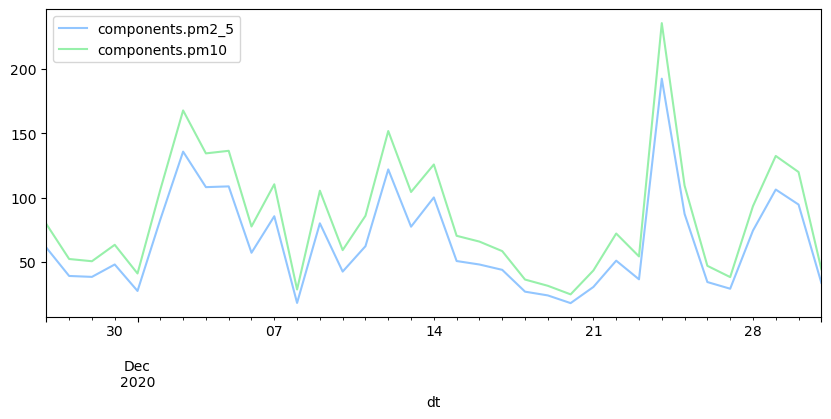

In [34]:
# plot daily average of pollutants using pandas
# version 1
daily[['components.pm2_5', 'components.pm10']].plot()
plt.show()

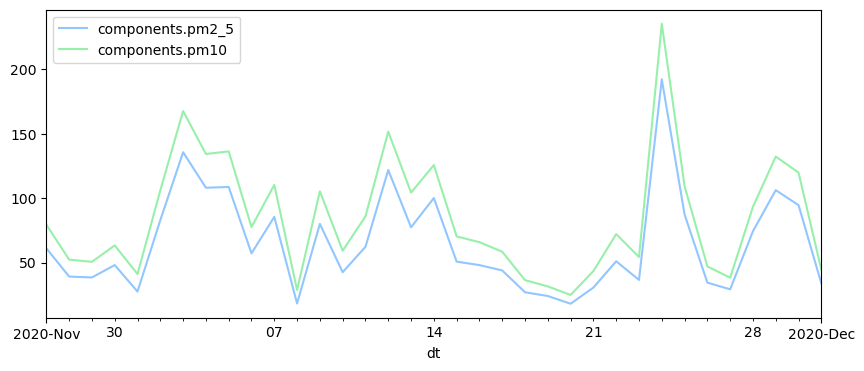

In [35]:
# version 2
ax = daily[['components.pm2_5', 'components.pm10']].plot()

# change the step of range() as preferred
ax.xaxis.set_major_locator(mdates.MonthLocator(bymonth=range(1,12,1)))
ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%b'))

plt.show()

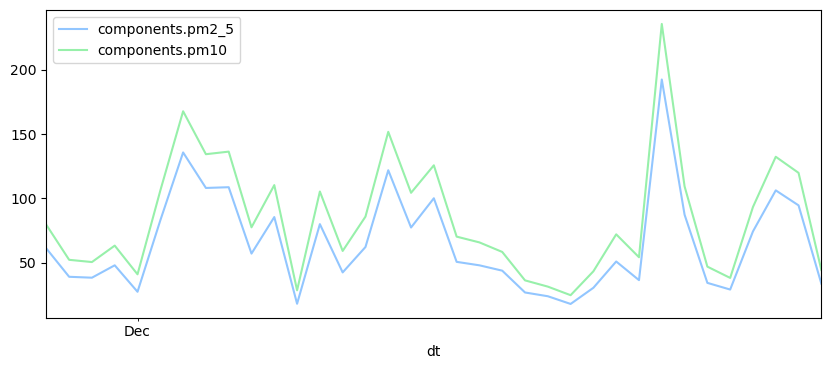

In [36]:
# version 3
ax = daily[['components.pm2_5', 'components.pm10']].plot()

fmt_month = mdates.MonthLocator()
fmt_year = mdates.YearLocator()

ax.xaxis.set_minor_locator(fmt_month)
ax.xaxis.set_minor_formatter(mdates.DateFormatter('%b'))

ax.xaxis.set_major_locator(fmt_year)
ax.xaxis.set_major_formatter(mdates.DateFormatter('\n%Y'))

plt.setp(ax.xaxis.get_minorticklabels(), rotation=0)
plt.setp(ax.xaxis.get_majorticklabels(), rotation=90)

plt.show()

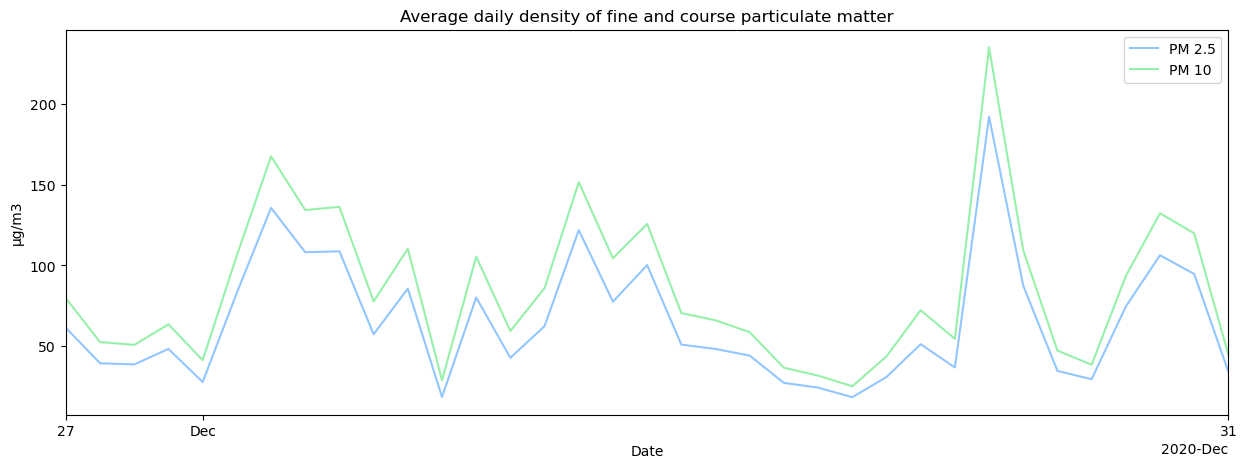

In [100]:
# version 4
ax = daily[['components.pm2_5', 'components.pm10']].plot()

# add minor ticks every month
fmt_month = mdates.MonthLocator()
ax.xaxis.set_minor_locator(fmt_month)
# set major formatter
ax.xaxis.set_major_formatter(mdates.ConciseDateFormatter(ax.xaxis.get_major_locator()))

# modify legend labels
ax.legend(labels = ['PM 2.5', 'PM 10'])
# set axes labels
plt.xlabel("Date")
plt.ylabel("μg/m3")
plt.title("Average daily density of fine and course particulate matter")

plt.show()

We will try to automate generation of plots per component. 

In [37]:
# keep only relevant columns 
compsdf = daily[['components.so2', 'components.no2', 'components.pm10', 'components.pm2_5', 'components.o3', 'components.co']]
compsdf.head()

,components.so2,components.no2,components.pm10,components.pm2_5,components.o3,components.co
dt,,,,,,
2020-11-27,40.601250,38.799583,79.540417,61.204167,6.840417,2159.039583
2020-11-28,29.807917,27.247500,52.397083,39.228750,16.487083,1390.497500
2020-11-29,26.265417,29.889167,50.664167,38.522917,12.712500,1364.629167
2020-11-30,22.500417,30.845000,63.410833,48.140000,35.037917,1491.328750
2020-12-01,25.630417,35.279167,41.156667,27.589583,40.679583,1034.459167


In [38]:
# rename columns
compsdf.columns 
compsdf.columns = [re.sub("components.", "", x) for x in compsdf.columns]
compsdf.head()

,so2,no2,pm10,pm2_5,o3,co
dt,,,,,,
2020-11-27,40.601250,38.799583,79.540417,61.204167,6.840417,2159.039583
2020-11-28,29.807917,27.247500,52.397083,39.228750,16.487083,1390.497500
2020-11-29,26.265417,29.889167,50.664167,38.522917,12.712500,1364.629167
2020-11-30,22.500417,30.845000,63.410833,48.140000,35.037917,1491.328750
2020-12-01,25.630417,35.279167,41.156667,27.589583,40.679583,1034.459167


In [39]:
# set bounds per category
# an upper bound is added to limit the y-axis 
bounds = {
    'so2': [0, 20, 80, 250, 350, 370],
    'no2': [0, 40, 70, 150, 200, 240],
    'pm10': [0, 20, 50, 100, 200, 220],
    'pm2_5': [0, 10, 25, 50, 75, 85],
    'o3': [0, 60, 100, 140, 180, 240],
    'co': [0, 4400, 9400, 12400, 15400, 19800]
}

# set title names
titles = {
    'so2': "$SO_2$",
    'no2': "$NO_2$",
    'pm10': "$PM_10$",
    'pm2_5': "$PM_2.5$",
    'o3': "$O_3$",
    'co': "$CO$"
}

# set colors of regions from bottom to top (green to red)
color = ['#1a9641', '#a6d96a', '#ffffbf', '#fdae61', '#d7191c']
# set transparency of color regions
ALPHA = 0.3

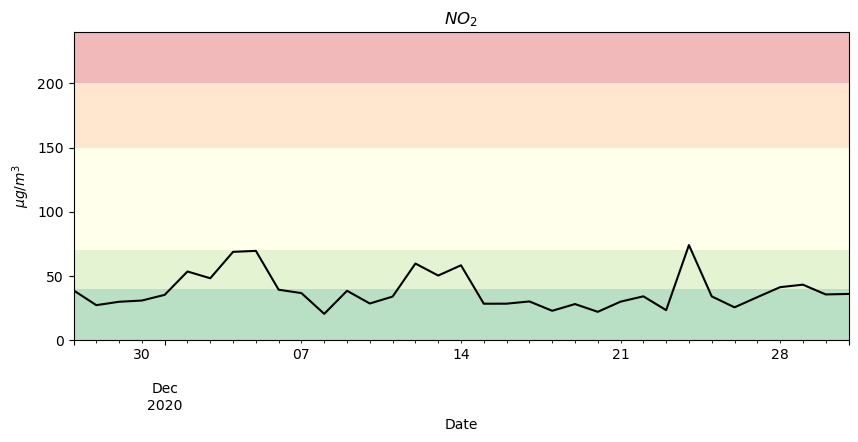

In [40]:
# decide column of interest (this will be the index of the for loop
comp = compsdf.columns[1]
# plot values
ax = compsdf[comp].plot(color='black')
# remove margins and set limits of y axis based on ranges of categories
ax.margins(0)
ax.set_ylim(bounds[comp][0], bounds[comp][5])
# color regions
for i in range(5):
    ax.axhspan(bounds[comp][i], bounds[comp][i + 1], facecolor=color[i], alpha=ALPHA)

# set labels
plt.xlabel("Date")
plt.ylabel("$μg/m^3$")
plt.title(titles[comp])

plt.show()

We can also check the variation of particulate matter concentrations per month.

In [41]:
# reset index 
df = df.reset_index()

In [42]:
# extract month and year
# format month as month name
df['month'] = df['dt'].dt.strftime('%b')
df['year'] = df['dt'].dt.year
df.head()

,index,dt,main.aqi,components.co,components.no,components.no2,components.o3,components.so2,components.pm2_5,components.pm10,components.nh3,month,year
0,0,2020-11-27 00:00:00,4,1214.98,0.05,40.10,23.60,21.46,33.63,45.66,6.52,Nov,2020
1,1,2020-11-27 01:00:00,4,1281.74,0.12,41.47,16.81,20.74,35.85,48.27,7.03,Nov,2020
2,2,2020-11-27 02:00:00,4,1375.20,0.22,41.13,12.34,21.70,41.63,56.26,9.63,Nov,2020
3,3,2020-11-27 03:00:00,4,1455.31,0.55,40.78,8.32,23.60,47.88,64.22,12.16,Nov,2020
4,4,2020-11-27 04:00:00,5,1508.71,1.69,40.78,3.67,28.61,54.58,72.08,15.83,Nov,2020


/Users/amlicuanan/miniconda3/envs/cs50x/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amlicuanan/miniconda3/envs/cs50x/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amlicuanan/miniconda3/envs/cs50x/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will be removed in a future version. Use isinstance(dtype, CategoricalDtype) instead
  if pd.api.types.is_categorical_dtype(vector):
/Users/amlicuanan/miniconda3/envs/cs50x/lib/python3.11/site-packages/seaborn/_oldcore.py:1498: FutureWarning: is_categorical_dtype is deprecated and will 

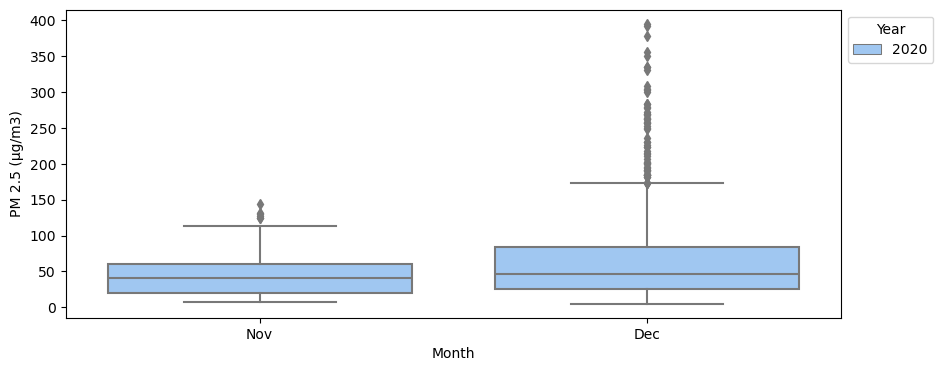

In [43]:
# create boxplots per month, colored by year
box = sns.boxplot(data = df, x = 'month', y = 'components.pm2_5', hue = "year")

# move legend outside of plot
sns.move_legend(box, "upper left", bbox_to_anchor=(1, 1), title = "Year")

# add axes names
plt.xlabel("Month")
plt.ylabel("PM 2.5 (μg/m3)")

plt.show()